In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Test GPU

In [ ]:
import torch
print("Torch version:", torch.__version__)
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)
if cuda_available:
    print("GPU Name:", torch.cuda.get_device_name(0))
    print(" CUDA version (PyTorch built with):", torch.version.cuda)
    print("GPU Memory Total (MB):", round(torch.cuda.get_device_properties(0).total_memory / 1024**2, 2))
else:
    print(" CUDA not available. Running on CPU.")

# Clear all non-building related labels

In [2]:
import os
import shutil

In [1]:
input_dir = "/kaggle/input/xview-yolo-dataset/images"
output_dir = "/kaggle/working/filtered_dataset"
os.makedirs(output_dir, exist_ok=True)

files = os.listdir(input_dir)

for file in files:
    file_path = os.path.join(input_dir, file)
    shutil.copy(file_path, output_dir)

#filtering such that only building is remaining 
for file in os.listdir(output_dir):
    if file.endswith(".txt"):
        txt_path = os.path.join(output_dir, file)
        img_name = file.replace(".txt", ".jpg")
        img_path = os.path.join(output_dir, img_name)
        
        with open(txt_path, "r") as f:
            lines = f.readlines()
        
        building_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5 and parts[0] == "48":
                parts[0] = "0"  # convert 48 → 0, only 1 class to be predicted 
                building_lines.append(" ".join(parts) + "\n")
        
        if building_lines:
            with open(txt_path, "w") as f:
                f.writelines(building_lines)
        else:
            # No buildings — delete label and image
            os.remove(txt_path)
            if os.path.exists(img_path):
                os.remove(img_path)

print("done filtering. all labels are now only for buildings.")

done filtering. all labels are now only for buildings.


In [3]:
base_dir = "/kaggle/working/filtered_dataset"
img_dir = os.path.join(base_dir, "images")
lbl_dir = os.path.join(base_dir, "labels")

os.makedirs(img_dir, exist_ok=True)
os.makedirs(lbl_dir, exist_ok=True)

for file in os.listdir(base_dir):
    path = os.path.join(base_dir, file)
    if file.endswith(".jpg"):
        shutil.move(path, os.path.join(img_dir, file))
    elif file.endswith(".txt"):
        shutil.move(path, os.path.join(lbl_dir, file))

print("done splitting")

done splitting


# image check

In [10]:
import cv2
import os
img_path = "/kaggle/working/filtered_dataset/images/img_323_1280_1920.jpg"
label_path = "/kaggle/working/filtered_dataset/labels/img_323_1280_1920.txt"

img = cv2.imread(img_path)
h, w = img.shape[:2]
with open(label_path, "r") as f:
    for line in f:
        cls, x, y, bw, bh = map(float, line.split())
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(img, str(int(cls)), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
cv2.imwrite("check_labels.jpg", img)

True

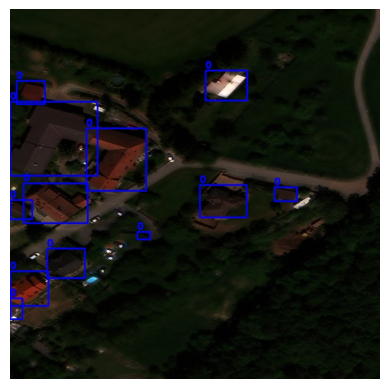

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/kaggle/working/check_labels.jpg'

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')  
plt.show()


# splitting into train/val/test

In [ ]:
import os
import random
from glob import glob

In [9]:
from glob import glob
import random

all_images = glob("/kaggle/working/filtered_dataset/images/*.jpg")
random.shuffle(all_images)

split1 = int(0.8 * len(all_images))
split2 = int(0.9 * len(all_images))

train_images = all_images[:split1]
val_images = all_images[split1:split2]
test_images = all_images[split2:]

with open("/kaggle/working/train.txt", "w") as f:
    f.writelines([p + "\n" for p in train_images])

with open("/kaggle/working/val.txt", "w") as f:
    f.writelines([p + "\n" for p in val_images])

with open("/kaggle/working/test.txt", "w") as f:
    f.writelines([p + "\n" for p in test_images])

In [12]:
yaml_content = """
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt
test: /kaggle/working/test.txt
nc: 1
names:
  0: Building
"""

with open("/kaggle/working/xview_yolo.yaml", "w") as f:
    f.write(yaml_content)

# Recheck image size (images smaller than 10x10)

In [13]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
img_dir = Path("/kaggle/working/filtered_dataset/images")
all_images = list(img_dir.glob("*.jpg"))
total_images = len(all_images)
bad_images = []
for img_path in sorted(all_images):
    img = cv2.imread(str(img_path))
    if img is None or img.shape[0] < 10 or img.shape[1] < 10:
        bad_images.append((img_path, img))
print(f" Total images: {total_images}")
print(f"Undersized/Corrupt images (<10x10): {len(bad_images)}")

 Total images: 10644
Undersized/Corrupt images (<10x10): 2


# Train model

In [ ]:
#  !rm -rf /kaggle/working/runs
# !rm -rf /kaggle/working/state.db
# !rm -rf /kaggle/working/labels.cache

In [3]:
!pip install ultralytics
from ultralytics import YOLO
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [4]:
print(f"using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"torch version: {torch.__version__}")

using device: Tesla T4
torch version: 2.6.0+cu124


In [5]:
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [8]:
model = YOLO("yolo11m.pt") 

In [ ]:
model.train(
    data="/kaggle/working/xview_yolo.yaml",
    epochs=10,
    imgsz=640,
    batch=8,
    device="cuda" if torch.cuda.is_available() else "cpu",
    name="xview_yolov11_m_run_1",
)

# Training 20 epoch :  Trying for medium variant, for 20 , 30 and 50 epochs 

In [19]:
model = YOLO("yolo11m.pt") 

In [ ]:
model.train(
    data="/kaggle/working/xview_yolo.yaml",
    epochs=20,
    imgsz=640,
    batch=8,
    device="cuda" if torch.cuda.is_available() else "cpu",
    name="xview_yolov11m_buildings_run_2"
)

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/xview_yolo.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xview_yolov11m_buildings_run_2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

train: Scanning /kaggle/working/filtered_dataset/labels... 8514 images, 0 backgrounds, 1 corrupt: 100%|██████████| 8515/8515 [00:07<00:00, 1065.48it/s]

train: /kaggle/working/filtered_dataset/images/img_1140_3200_1920.jpg: ignoring corrupt image/label: image size (4, 4) <10 pixels


train: New cache created: /kaggle/working/filtered_dataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 295.2±151.2 MB/s, size: 92.8 KB)


val: Scanning /kaggle/working/filtered_dataset/labels... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:01<00:00, 993.16it/s] 

val: New cache created: /kaggle/working/filtered_dataset/labels.cache


Plotting labels to runs/detect/xview_yolov11m_buildings_run_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/xview_yolov11m_buildings_run_2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       7.4G      1.972       1.61      1.527        228        640: 100%|██████████| 1065/1065 [06:00<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.16it/s]


                   all       1064      38007      0.448      0.421      0.354      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.54G      1.978      1.574       1.53         53        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.00it/s]


                   all       1064      38007      0.522      0.451       0.43      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.61G       1.95      1.515      1.508        116        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


                   all       1064      38007      0.517      0.477      0.441      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.61G      1.913      1.479      1.492        118        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]


                   all       1064      38007      0.542      0.479      0.456      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.61G      1.894      1.446      1.478         35        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


                   all       1064      38007      0.561      0.504       0.49      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.62G      1.856      1.407      1.462         17        640: 100%|██████████| 1065/1065 [05:46<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.07it/s]


                   all       1064      38007      0.569      0.493      0.481      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.62G      1.843      1.364      1.444         15        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.07it/s]


                   all       1064      38007      0.575      0.512      0.498      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.62G      1.826      1.356      1.432        195        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.579      0.531      0.518       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.62G      1.819      1.329       1.43        141        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


                   all       1064      38007      0.595      0.533      0.529      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.81G      1.805      1.306      1.419         86        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.596      0.534      0.527      0.265
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.11G       1.79       1.37      1.474          4        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


                   all       1064      38007      0.597      0.538      0.531      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.38G      1.772      1.334      1.465         29        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


                   all       1064      38007      0.602       0.55      0.544      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.65G      1.764      1.316       1.46          8        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.13it/s]


                   all       1064      38007      0.603      0.547      0.541      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.57G      1.752      1.288      1.444         30        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.617      0.542      0.548      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.97G      1.742      1.287      1.447        178        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


                   all       1064      38007      0.619      0.557      0.561      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       8.5G      1.726      1.262      1.432         83        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.616      0.557      0.562      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.73G      1.713      1.243      1.432         90        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.622       0.56      0.565      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.43G      1.703      1.228      1.424         45        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.07it/s]


                   all       1064      38007      0.622      0.561      0.566      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.01G      1.692      1.217      1.413        239        640:  41%|████      | 437/1065 [02:20<03:22,  3.10it/s]

In [22]:
print('done')

done


In [7]:
# !rm -rf /kaggle/working/runs/detect/xview_yolov11m_buildings_run_22

In [23]:
# !rm -rf /kaggle/working/runs/detect/predict
# !rm -rf /kaggle/working/runs/detect/predict2
# !rm -rf /kaggle/working/runs/detect/predict3
# !rm -rf /kaggle/working/runs/detect/predict4
# !rm -rf /kaggle/working/runs/detect/predict5
# !rm -rf /kaggle/working/runs/detect/predict6
# !rm -rf /kaggle/working/runs/detect/predict7
# !rm -rf /kaggle/working/runs/detect/predict8
# !rm -rf /kaggle/working/runs/detect/predict9
# !rm -rf /kaggle/working/runs/detect/predict10
# !rm -rf /kaggle/working/runs/detect/predict11

# !rm -rf /kaggle/working/runs/detect/predict12
# !rm -rf /kaggle/working/runs/detect/predict13
# !rm -rf /kaggle/working/runs/detect/predict14
# !rm -rf /kaggle/working/runs/detect/predict15
# !rm -rf /kaggle/working/runs/detect/predict16
# !rm -rf /kaggle/working/runs/detect/predict17
# !rm -rf /kaggle/working/runs/detect/predict18
# !rm -rf /kaggle/working/runs/detect/predict19
# !rm -rf /kaggle/working/runs/detect/predict20
# !rm -rf /kaggle/working/runs/detect/predict21
# !rm -rf /kaggle/working/runs/detect/predict22

# !rm -rf /kaggle/working/runs/detect/predict23
# !rm -rf /kaggle/working/runs/detect/predict24
# !rm -rf /kaggle/working/runs/detect/predict25
# !rm -rf /kaggle/working/runs/detect/predict26
# !rm -rf /kaggle/working/runs/detect/predict27
# !rm -rf /kaggle/working/runs/detect/predict28
# !rm -rf /kaggle/working/runs/detect/predict29
# !rm -rf /kaggle/working/runs/detect/predict30
# !rm -rf /kaggle/working/runs/detect/predict31
# !rm -rf /kaggle/working/runs/detect/predict31
# !rm -rf /kaggle/working/runs/detect/predict32

# !rm -rf /kaggle/working/runs/detect/predict33
# !rm -rf /kaggle/working/runs/detect/predict34
# !rm -rf /kaggle/working/runs/detect/predict35
# !rm -rf /kaggle/working/runs/detect/predict36
# !rm -rf /kaggle/working/runs/detect/predict37
# !rm -rf /kaggle/working/runs/detect/predict38

# Validation at 20 epoch

In [26]:
model = YOLO("/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt")
metrics = model.val(data="/kaggle/working/xview_yolo.yaml", imgsz=640, verbose=False)
print('done validation')

Ultralytics 8.3.163 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1053.1±895.2 MB/s, size: 73.2 KB)


val: Scanning /kaggle/working/filtered_dataset/labels.cache... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:37<00:00,  1.77it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1064      38007      0.631      0.569      0.577      0.302
Speed: 0.4ms preprocess, 27.6ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val
done validation


In [ ]:
# results_dict: {'metrics/precision(B)': 0.6306701734792387, 
# 'metrics/recall(B)': 0.5694477333122846, 
# 'metrics/mAP50(B)': 0.576905419821616,
# 'metrics/mAP50-95(B)': 0.30226398378086816, 
# 'fitness': 0.32972812738494295}

# Inference at 20 epoch

In [32]:

model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.25)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 1 Building, 33.0ms
1: 640x640 1 Building, 33.0ms
2: 640x640 9 Buildings, 33.0ms
Speed: 2.4ms preprocess, 33.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
Predictions saved in: runs/detect/predict


In [33]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.25, augment = True)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 1 Building, 73.5ms
1: 640x640 1 Building, 73.5ms
2: 640x640 15 Buildings, 73.5ms
Speed: 2.2ms preprocess, 73.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2
Predictions saved in: runs/detect/predict2


In [34]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=896, conf=0.25, augment = True)

print("Predictions saved in:", results[0].save_dir)


0: 896x896 (no detections), 108.1ms
1: 896x896 1 Building, 108.1ms
2: 896x896 11 Buildings, 108.1ms
Speed: 3.9ms preprocess, 108.1ms inference, 0.9ms postprocess per image at shape (1, 3, 896, 896)
Results saved to runs/detect/predict3
Predictions saved in: runs/detect/predict3


In [35]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=1024, conf=0.25, augment = True)

print("Predictions saved in:", results[0].save_dir)


0: 1024x1024 (no detections), 141.4ms
1: 1024x1024 (no detections), 141.4ms
2: 1024x1024 5 Buildings, 141.4ms
Speed: 4.9ms preprocess, 141.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/detect/predict4
Predictions saved in: runs/detect/predict4


In [36]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=896, conf=0.1, augment = True)

print("Predictions saved in:", results[0].save_dir)


0: 896x896 3 Buildings, 108.3ms
1: 896x896 5 Buildings, 108.3ms
2: 896x896 73 Buildings, 108.3ms
Speed: 4.0ms preprocess, 108.3ms inference, 1.1ms postprocess per image at shape (1, 3, 896, 896)
Results saved to runs/detect/predict5
Predictions saved in: runs/detect/predict5


In [37]:
# BEST RESULT SO FAR
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 3 Buildings, 77.3ms
1: 640x640 5 Buildings, 77.3ms
2: 640x640 118 Buildings, 77.3ms
Speed: 2.3ms preprocess, 77.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict6
Predictions saved in: runs/detect/predict6


In [38]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True, iou=0.7)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 3 Buildings, 65.6ms
1: 640x640 5 Buildings, 65.6ms
2: 640x640 118 Buildings, 65.6ms
Speed: 2.2ms preprocess, 65.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7
Predictions saved in: runs/detect/predict7


In [39]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True, iou=0.6)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 3 Buildings, 72.3ms
1: 640x640 5 Buildings, 72.3ms
2: 640x640 105 Buildings, 72.3ms
Speed: 2.2ms preprocess, 72.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict8
Predictions saved in: runs/detect/predict8


In [40]:
# BEST RESULT SO FAR - NEW BASED ON IOU
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True, iou=0.9)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 4 Buildings, 71.4ms
1: 640x640 9 Buildings, 71.4ms
2: 640x640 215 Buildings, 71.4ms
Speed: 2.2ms preprocess, 71.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict9
Predictions saved in: runs/detect/predict9


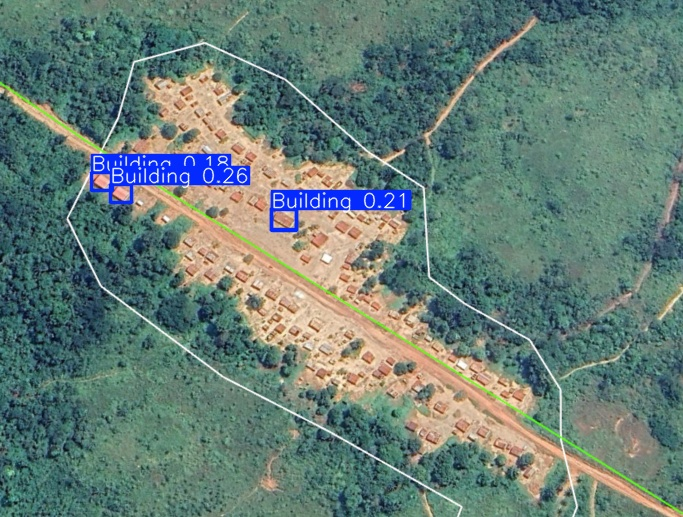

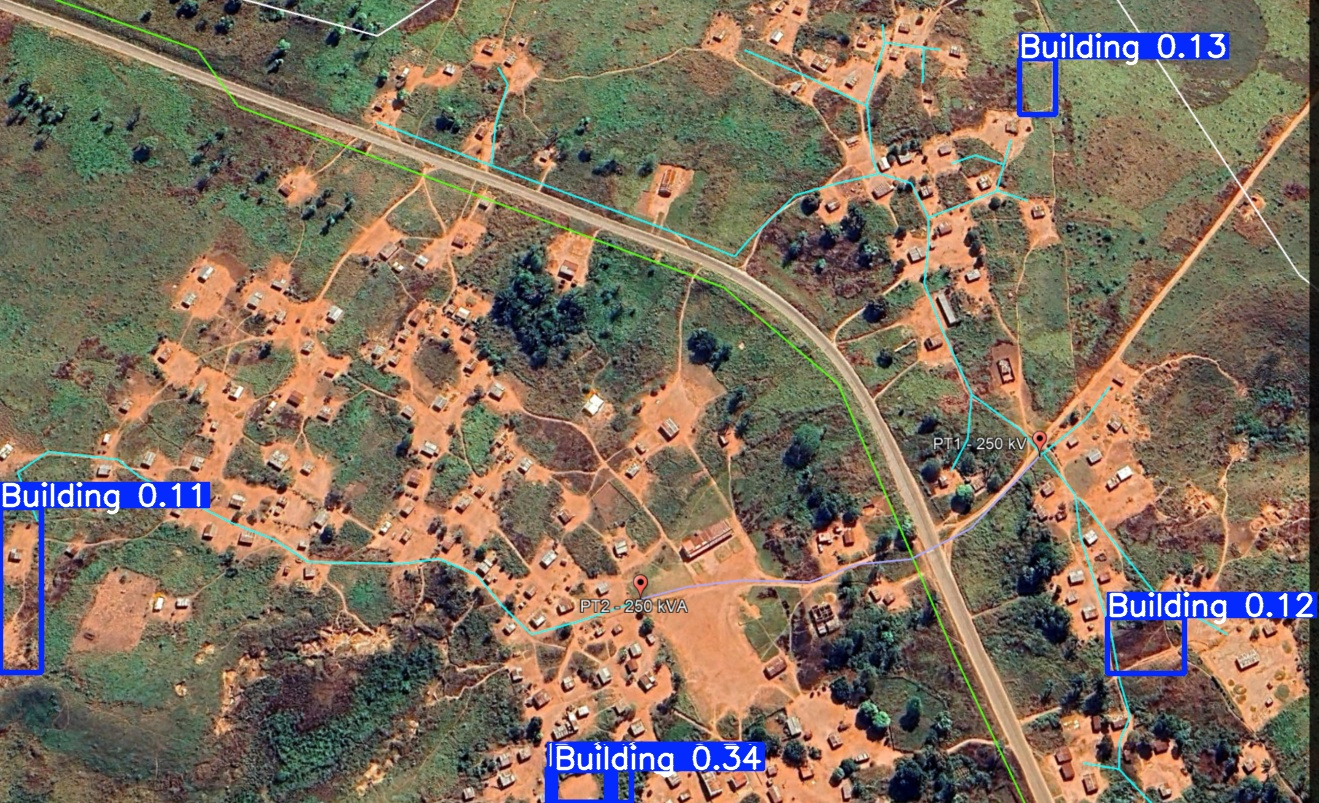

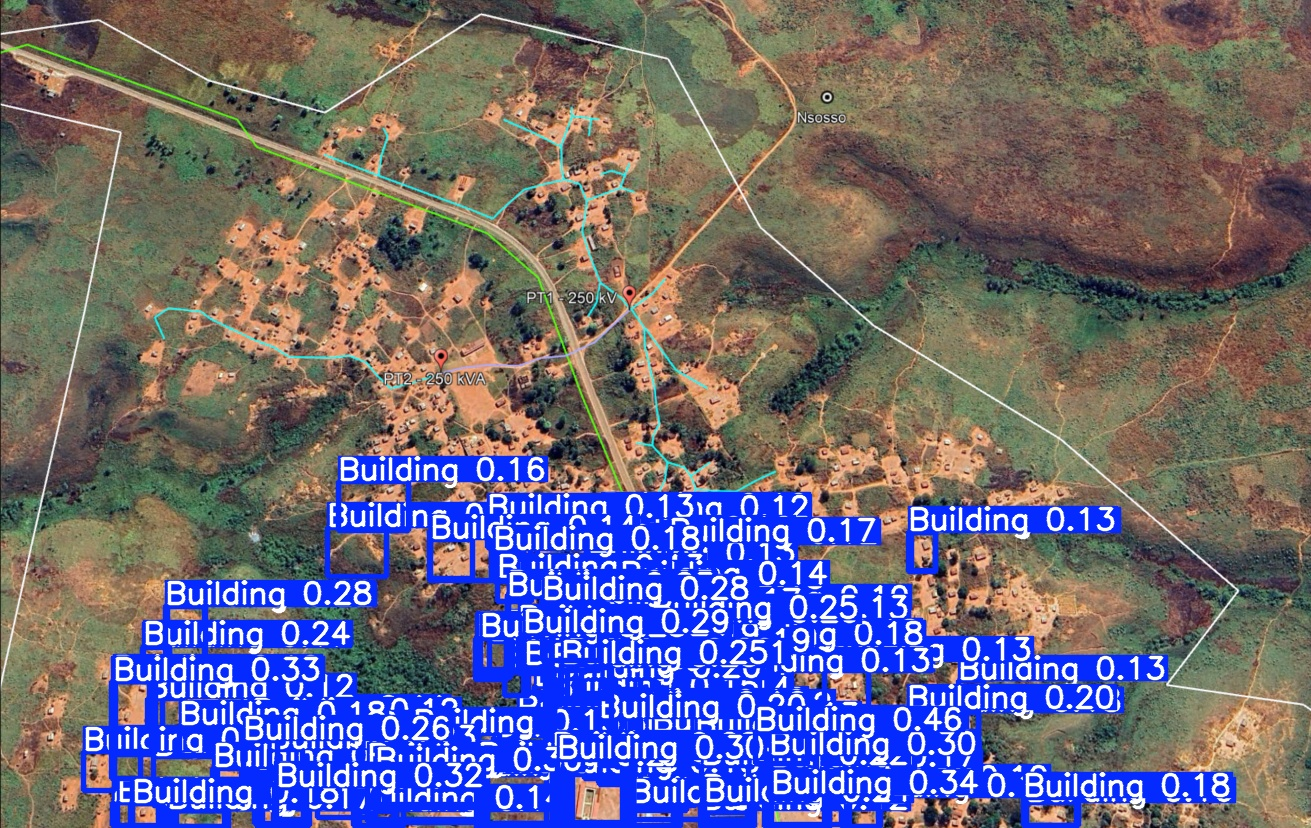

In [41]:
from IPython.display import Image, display

for i in range(1,4):
    display(Image(filename=f'/kaggle/working/runs/detect/predict9/{i}.jpg'))

In [42]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 3 Buildings, 65.7ms
1: 640x640 5 Buildings, 65.7ms
2: 640x640 118 Buildings, 65.7ms
Speed: 2.3ms preprocess, 65.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict10
Predictions saved in: runs/detect/predict10


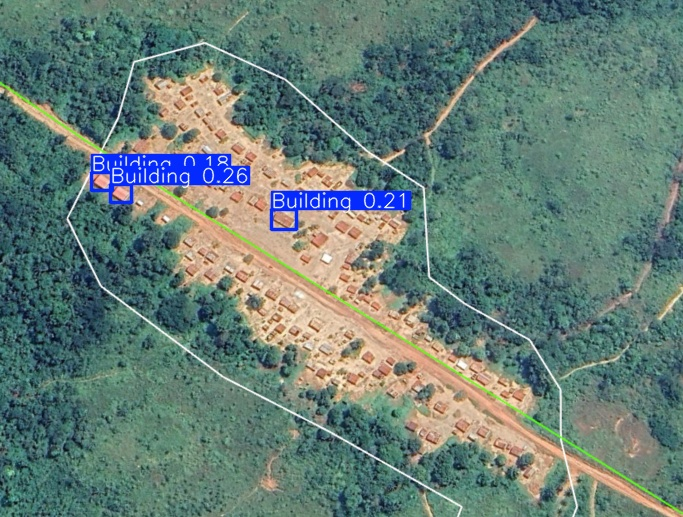

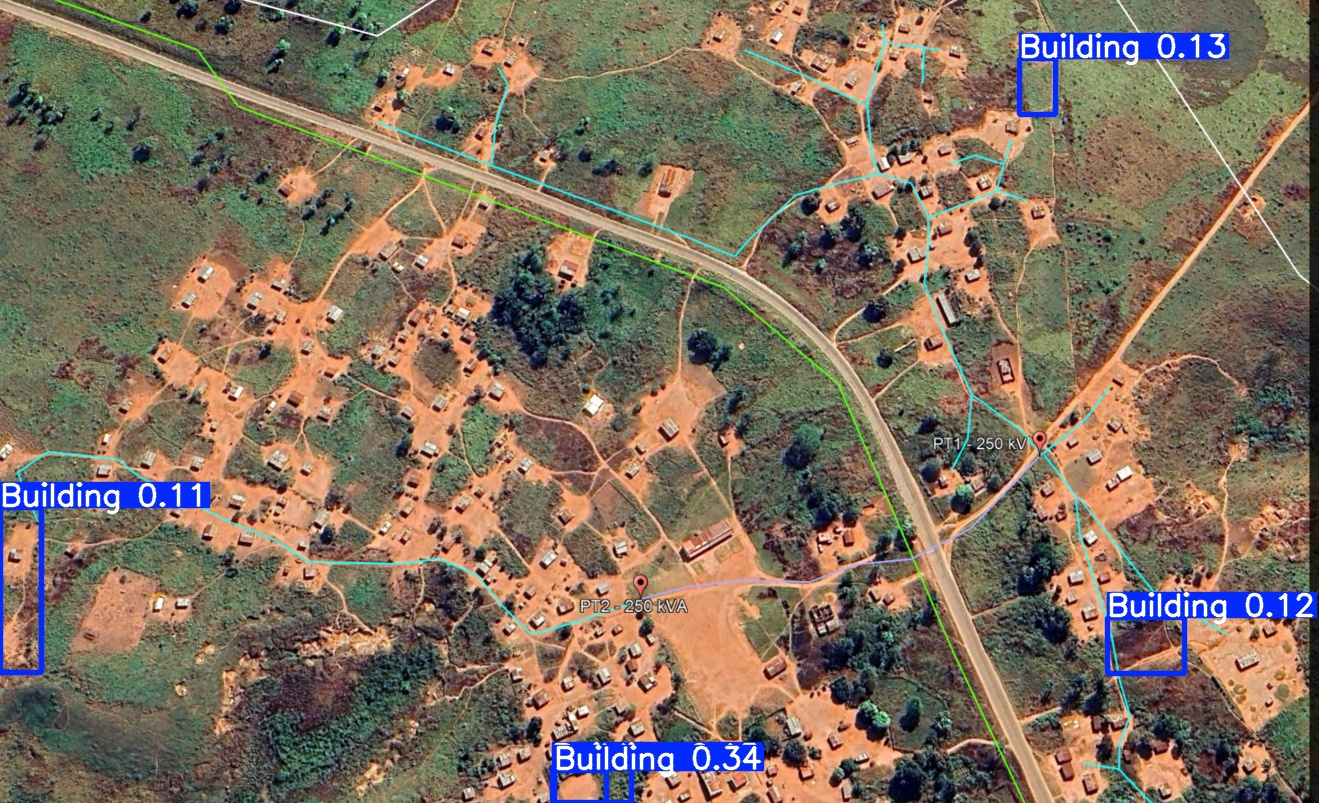

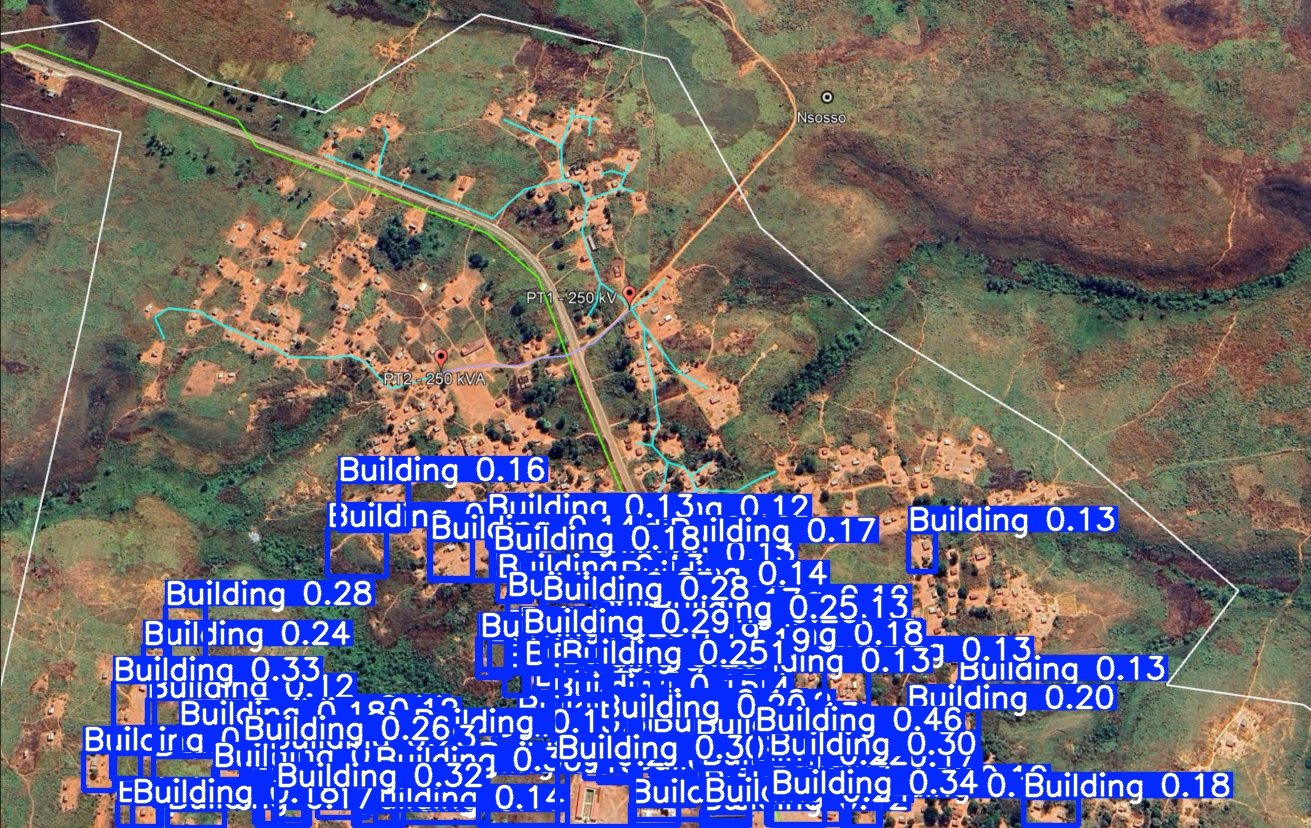

In [43]:
from IPython.display import Image, display

for i in range(1,4):
    display(Image(filename=f'/kaggle/working/runs/detect/predict10/{i}.jpg'))

# Training 30 epoch

In [29]:
model.train(
    data="/kaggle/working/xview_yolo.yaml",
    epochs=30,
    imgsz=640,
    batch=8,
    device="cuda" if torch.cuda.is_available() else "cpu",
    name="xview_yolov11m_buildings_run_3",
)

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/xview_yolo.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/runs/detect/xview_yolov11m_buildings_run_2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xview_yolov11m_buildings_run_3, nbs=64, nms=False, opset=None, optimize=False, optimizer=a

train: Scanning /kaggle/working/filtered_dataset/labels... 8514 images, 0 backgrounds, 1 corrupt: 100%|██████████| 8515/8515 [00:07<00:00, 1136.93it/s]

train: /kaggle/working/filtered_dataset/images/img_1140_3200_1920.jpg: ignoring corrupt image/label: image size (4, 4) <10 pixels


train: New cache created: /kaggle/working/filtered_dataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 610.3±593.4 MB/s, size: 92.8 KB)


val: Scanning /kaggle/working/filtered_dataset/labels... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<00:00, 1105.23it/s]

val: New cache created: /kaggle/working/filtered_dataset/labels.cache


Plotting labels to runs/detect/xview_yolov11m_buildings_run_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/xview_yolov11m_buildings_run_3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.44G      1.937      1.463      1.533        228        640: 100%|██████████| 1065/1065 [06:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]


                   all       1064      38007      0.577       0.52      0.509      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.79G       1.85      1.339      1.454         53        640: 100%|██████████| 1065/1065 [05:53<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.586      0.515       0.51      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.14G       1.84      1.345      1.443        116        640: 100%|██████████| 1065/1065 [05:50<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.571      0.515      0.499       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.43G      1.827       1.34      1.439        118        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.01it/s]


                   all       1064      38007      0.576      0.519      0.502      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.46G      1.814      1.316      1.425         35        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.02it/s]


                   all       1064      38007      0.584      0.528      0.518      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.34G       1.79      1.297       1.42         17        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.601      0.527      0.526      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.77G      1.784      1.273      1.407         15        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.05it/s]


                   all       1064      38007      0.606      0.545       0.54      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.72G      1.771      1.264        1.4        195        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.601      0.559      0.543      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.73G      1.771      1.252      1.398        141        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.612      0.541      0.543      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.98G      1.761      1.239      1.391         86        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.613      0.554      0.549       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.77G      1.744       1.24      1.388          4        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.605      0.558      0.545      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.93G      1.738      1.227      1.384         21        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.12it/s]


                   all       1064      38007      0.617      0.554      0.553      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.27G      1.731      1.221      1.375         27        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.617      0.562      0.561      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.33G      1.735      1.218      1.379         43        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.629      0.559      0.567      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.69G      1.717      1.196      1.369         28        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007       0.63       0.57      0.573      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.81G      1.724        1.2      1.372        179        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.629      0.563       0.57      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.57G      1.723      1.196      1.373         49        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.07it/s]


                   all       1064      38007      0.618      0.566      0.562      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.02G      1.708       1.19      1.363         16        640: 100%|██████████| 1065/1065 [05:49<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


                   all       1064      38007      0.623      0.572      0.571      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.04G      1.701      1.181      1.364         46        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.625      0.574      0.574        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.23G      1.699      1.173      1.359         18        640: 100%|██████████| 1065/1065 [05:48<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.634       0.57      0.577      0.301
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.38G      1.685      1.205      1.402          5        640: 100%|██████████| 1065/1065 [05:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


                   all       1064      38007      0.638       0.57      0.579      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.78G      1.683      1.205      1.394          2        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:22<00:00,  3.04it/s]


                   all       1064      38007      0.642       0.57      0.579      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.64G      1.675       1.19      1.395          6        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.642      0.576      0.585      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.08G      1.667      1.177      1.387        102        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.642      0.574      0.587      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.29G      1.663      1.171      1.391         14        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.648      0.574      0.588      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.28G      1.658      1.151      1.382         21        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.648      0.575       0.59      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.14G      1.658      1.156      1.382         36        640: 100%|██████████| 1065/1065 [05:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.647      0.574      0.588       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.46G      1.638       1.14       1.37          9        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.05it/s]


                   all       1064      38007      0.647      0.575      0.589      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.75G      1.643      1.141      1.373          2        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.07it/s]


                   all       1064      38007      0.649      0.578       0.59      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.22G      1.637      1.134      1.373         29        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.06it/s]


                   all       1064      38007      0.651       0.58      0.593      0.315

30 epochs completed in 3.099 hours.
Optimizer stripped from runs/detect/xview_yolov11m_buildings_run_3/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/xview_yolov11m_buildings_run_3/weights/best.pt, 40.5MB

Validating runs/detect/xview_yolov11m_buildings_run_3/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 2/67 [00:00<00:21,  2.97it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:23<00:00,  2.81it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1064      38007      0.651      0.578      0.592      0.315
Speed: 0.2ms preprocess, 11.2ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/xview_yolov11m_buildings_run_3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d824ccb3550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [30]:
print('done')

done


# Validation at 30 epoch

In [44]:
model = YOLO("/kaggle/working/runs/detect/xview_yolov11m_buildings_run_3/weights/best.pt")
metrics = model.val(data="/kaggle/working/xview_yolo.yaml", imgsz=640, verbose=False)
print('done validation')

Ultralytics 8.3.163 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2160.8±1157.2 MB/s, size: 118.9 KB)


val: Scanning /kaggle/working/filtered_dataset/labels.cache... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:38<00:00,  1.76it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1064      38007      0.652      0.579      0.593      0.315
Speed: 0.4ms preprocess, 27.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val2
done validation


In [46]:
#results_dict: {'metrics/precision(B)': 0.6517725770034789, 
#'metrics/recall(B)': 0.5794985134317363,
#'metrics/mAP50(B)': 0.5930645036689786, 
#'metrics/mAP50-95(B)': 0.315142545452711, 
#'fitness': 0.34293474127433776}

# Inference 30 epoch

In [47]:
# xview_yolov11m_buildings_run_3 => 30 epochs
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_3/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 70.1ms
1: 640x640 3 Buildings, 70.1ms
2: 640x640 5 Buildings, 70.1ms
Speed: 2.3ms preprocess, 70.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict11
Predictions saved in: runs/detect/predict11


In [48]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_3/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True, iou=0.7)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 72.6ms
1: 640x640 3 Buildings, 72.6ms
2: 640x640 5 Buildings, 72.6ms
Speed: 2.2ms preprocess, 72.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict12
Predictions saved in: runs/detect/predict12


In [49]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_3/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True, iou=0.9)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 69.4ms
1: 640x640 5 Buildings, 69.4ms
2: 640x640 7 Buildings, 69.4ms
Speed: 2.4ms preprocess, 69.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict13
Predictions saved in: runs/detect/predict13


In [50]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_3/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment = True, iou=0.2)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 74.7ms
1: 640x640 3 Buildings, 74.7ms
2: 640x640 5 Buildings, 74.7ms
Speed: 2.4ms preprocess, 74.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict14
Predictions saved in: runs/detect/predict14


# Training 50 epochs

In [17]:
model = YOLO("yolo11m.pt") 

In [ ]:
model.train(
    data="/kaggle/working/xview_yolo.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    device="cuda" if torch.cuda.is_available() else "cpu",
    name="xview_yolov11m_buildings_run_4",
)

Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/xview_yolo.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xview_yolov11m_buildings_run_4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

train: Scanning /kaggle/working/filtered_dataset/labels... 8514 images, 0 backgrounds, 1 corrupt: 100%|██████████| 8515/8515 [00:06<00:00, 1260.97it/s]

train: /kaggle/working/filtered_dataset/images/img_1140_3200_1920.jpg: ignoring corrupt image/label: image size (4, 4) <10 pixels


train: New cache created: /kaggle/working/filtered_dataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 339.9±178.3 MB/s, size: 92.8 KB)


val: Scanning /kaggle/working/filtered_dataset/labels... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<00:00, 1200.48it/s]

val: New cache created: /kaggle/working/filtered_dataset/labels.cache


Plotting labels to runs/detect/xview_yolov11m_buildings_run_4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/xview_yolov11m_buildings_run_4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.62G      1.972       1.61      1.527        228        640: 100%|██████████| 1065/1065 [05:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


                   all       1064      38007      0.448      0.421      0.354      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.56G      1.982      1.578       1.53         53        640: 100%|██████████| 1065/1065 [05:47<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.09it/s]


                   all       1064      38007      0.493      0.472      0.416      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.42G       1.96      1.528      1.511        116        640: 100%|██████████| 1065/1065 [05:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.16it/s]


                   all       1064      38007       0.51      0.481      0.438      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.73G      1.925      1.498      1.494        118        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.08it/s]


                   all       1064      38007      0.515      0.474      0.432      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.09G      1.901      1.459       1.48         35        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.19it/s]


                   all       1064      38007      0.532      0.487      0.458      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.39G      1.868      1.427      1.471         17        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.19it/s]


                   all       1064      38007      0.554      0.504      0.481      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.51G      1.855      1.387      1.452         15        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.16it/s]


                   all       1064      38007      0.575      0.518      0.505      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.18G       1.84      1.378      1.444        195        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.17it/s]


                   all       1064      38007      0.584      0.531      0.518      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.49G      1.839      1.352      1.438        141        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.19it/s]


                   all       1064      38007      0.584      0.523      0.516      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.57G      1.825      1.333      1.431         86        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


                   all       1064      38007      0.596      0.522      0.516      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.36G      1.805      1.324      1.425          4        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.19it/s]


                   all       1064      38007      0.593      0.536      0.527      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.57G      1.794      1.312      1.418         21        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.17it/s]


                   all       1064      38007      0.597      0.538       0.53      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         9G      1.787      1.302      1.409         27        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.597      0.548      0.536      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.78G      1.794      1.297      1.418         43        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.583      0.537      0.516      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.14G       1.77      1.269        1.4         28        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


                   all       1064      38007       0.61      0.553      0.548       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.57G      1.778       1.27      1.406        179        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.604      0.545      0.541      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.41G      1.772      1.265      1.403         49        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.604      0.544      0.536      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.47G      1.763      1.264      1.396         16        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]


                   all       1064      38007      0.609      0.559      0.555      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.68G      1.751      1.248      1.397         46        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.621      0.557      0.558      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.82G      1.749      1.242      1.388         18        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.615      0.557      0.553      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.57G      1.742      1.234       1.38        124        640: 100%|██████████| 1065/1065 [05:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:21<00:00,  3.19it/s]


                   all       1064      38007      0.607      0.558      0.554      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.77G      1.748      1.233      1.385         41        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


                   all       1064      38007      0.614      0.559      0.556      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.77G      1.727       1.22      1.378         78        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


                   all       1064      38007      0.615      0.567      0.561      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.67G      1.732      1.215      1.375         29        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


                   all       1064      38007      0.626      0.565      0.569      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.41G      1.723      1.205      1.373         44        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


                   all       1064      38007      0.617      0.567      0.563      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       8.6G      1.717      1.194      1.369         65        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


                   all       1064      38007      0.627      0.567       0.57      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.17G       1.72      1.198      1.369         50        640: 100%|██████████| 1065/1065 [05:43<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.25it/s]


                   all       1064      38007      0.625       0.57      0.568      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       7.3G      1.716        1.2      1.371         56        640: 100%|██████████| 1065/1065 [05:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007      0.626      0.571      0.571      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       7.2G      1.713      1.189      1.367         93        640: 100%|██████████| 1065/1065 [05:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.26it/s]


                   all       1064      38007      0.623      0.574      0.572      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.37G        1.7       1.18      1.356         43        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.632      0.573      0.576      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.06G      1.701      1.176       1.36         30        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007       0.63      0.577      0.575      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.69G      1.694      1.162      1.359         19        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.23it/s]


                   all       1064      38007      0.633       0.58      0.579      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       8.1G      1.694      1.166      1.357         55        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007       0.63      0.574      0.576      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.48G      1.683      1.154      1.351        117        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007       0.64      0.577      0.585      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.05G      1.679      1.146       1.34         12        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007       0.64       0.58      0.584      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.97G      1.683      1.146      1.348         31        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007       0.64      0.582      0.586      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.91G      1.668      1.139      1.339         38        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007      0.641      0.582      0.587      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       7.4G      1.672      1.135      1.339         87        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


                   all       1064      38007      0.642      0.582      0.589      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.25G      1.671       1.13      1.339         57        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.23it/s]


                   all       1064      38007      0.641      0.586      0.589      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.95G      1.664      1.124      1.343         49        640: 100%|██████████| 1065/1065 [05:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007      0.644      0.585      0.589       0.31
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.51G      1.658      1.159      1.382          7        640: 100%|██████████| 1065/1065 [05:37<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


                   all       1064      38007      0.651       0.58      0.593      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.12G      1.647      1.142      1.382         22        640: 100%|██████████| 1065/1065 [05:37<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.21it/s]


                   all       1064      38007      0.654      0.577      0.594      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.81G      1.641      1.137      1.378        235        640: 100%|██████████| 1065/1065 [05:37<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.20it/s]


                   all       1064      38007      0.656      0.581      0.599      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.7G      1.632      1.115      1.365         52        640: 100%|██████████| 1065/1065 [05:36<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.24it/s]


                   all       1064      38007      0.656      0.582      0.599      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.32G      1.629      1.126      1.368         75        640: 100%|██████████| 1065/1065 [05:37<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:20<00:00,  3.23it/s]


                   all       1064      38007      0.657       0.58      0.597      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.07G      1.615      1.111      1.362        176        640:  93%|█████████▎| 989/1065 [05:13<00:24,  3.11it/s]

# Validation at 50 epochs

In [51]:
model = YOLO("/kaggle/working/runs/detect/xview_yolov11m_buildings_run_4/weights/best.pt")
metrics = model.val(data="/kaggle/working/xview_yolo.yaml", imgsz=640, verbose=False)
print('done validation')

Ultralytics 8.3.163 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1793.0±852.9 MB/s, size: 92.5 KB)


val: Scanning /kaggle/working/filtered_dataset/labels.cache... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:36<00:00,  1.82it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1064      38007      0.659      0.583        0.6       0.32
Speed: 0.5ms preprocess, 25.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val3
done validation


In [ ]:
#results_dict: {'metrics/precision(B)': 0.6586803003642521, 
#'metrics/recall(B)': 0.5833662220117347, 
#'metrics/mAP50(B)': 0.5998146035723124,
#'metrics/mAP50-95(B)': 0.3195825191403364, 
#'fitness': 0.34760572758353403}

# Inference at 50 epoch

In [53]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_4/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment=True)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 71.8ms
1: 640x640 4 Buildings, 71.8ms
2: 640x640 7 Buildings, 71.8ms
Speed: 2.5ms preprocess, 71.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict15
Predictions saved in: runs/detect/predict15


In [54]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_4/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment=True, iou=0.7)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 75.9ms
1: 640x640 4 Buildings, 75.9ms
2: 640x640 7 Buildings, 75.9ms
Speed: 2.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict16
Predictions saved in: runs/detect/predict16


In [55]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11m_buildings_run_4/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment=True, iou=0.9)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 74.5ms
1: 640x640 4 Buildings, 74.5ms
2: 640x640 12 Buildings, 74.5ms
Speed: 2.4ms preprocess, 74.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict17
Predictions saved in: runs/detect/predict17


# Inference at 10 epoch

In [16]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11_m_run_1/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 33.0ms
1: 640x640 2 Buildings, 33.0ms
2: 640x640 68 Buildings, 33.0ms
Speed: 2.7ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict16
Predictions saved in: runs/detect/predict16


In [17]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11_m_run_1/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.25)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 32.9ms
1: 640x640 (no detections), 32.9ms
2: 640x640 5 Buildings, 32.9ms
Speed: 2.3ms preprocess, 32.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict17
Predictions saved in: runs/detect/predict17


In [18]:
model = YOLO('/kaggle/working/runs/detect/xview_yolov11_m_run_1/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.5)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 33.2ms
1: 640x640 (no detections), 33.2ms
2: 640x640 (no detections), 33.2ms
Speed: 2.4ms preprocess, 33.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict18
Predictions saved in: runs/detect/predict18


# Trying large variant - 20 epochs

In [27]:
# !rm -rf /kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs

In [ ]:
model_large = YOLO("yolo11l.pt") 
model_large.train(
    data="/kaggle/working/xview_yolo.yaml",
    epochs=20,
    imgsz=640,
    batch=8,
    device="cuda" if torch.cuda.is_available() else "cpu",
    name="xview_yolov11l_buildings_large_run_20_epochs"
)

Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/xview_yolo.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xview_yolov11l_buildings_large_run_20_epochs, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

train: Scanning /kaggle/working/filtered_dataset/labels... 8514 images, 0 backgrounds, 1 corrupt: 100%|██████████| 8515/8515 [00:06<00:00, 1297.99it/s]

train: /kaggle/working/filtered_dataset/images/img_1140_3200_1920.jpg: ignoring corrupt image/label: image size (4, 4) <10 pixels


train: New cache created: /kaggle/working/filtered_dataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 480.4±338.0 MB/s, size: 92.8 KB)


val: Scanning /kaggle/working/filtered_dataset/labels... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<00:00, 1154.34it/s]


val: New cache created: /kaggle/working/filtered_dataset/labels.cache
Plotting labels to runs/detect/xview_yolov11l_buildings_large_run_20_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/xview_yolov11l_buildings_large_run_20_epochs
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.26G      1.973      1.575      1.569        228        640: 100%|██████████| 1065/1065 [07:45<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:27<00:00,  2.48it/s]


                   all       1064      38007      0.501      0.441      0.403      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.82G      1.985      1.565      1.569         53        640: 100%|██████████| 1065/1065 [07:32<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


                   all       1064      38007      0.497       0.45      0.405      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.62G      1.953      1.525      1.545        116        640: 100%|██████████| 1065/1065 [07:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


                   all       1064      38007      0.507       0.47      0.429      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         9G      1.918      1.481      1.527        118        640: 100%|██████████| 1065/1065 [07:28<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.58it/s]


                   all       1064      38007      0.535       0.47       0.45      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.2G      1.899      1.445      1.511         35        640: 100%|██████████| 1065/1065 [07:27<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.61it/s]


                   all       1064      38007      0.545      0.479      0.459      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.64G      1.858      1.408      1.497         17        640: 100%|██████████| 1065/1065 [07:26<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.64it/s]


                   all       1064      38007      0.573      0.499      0.489      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.74G      1.841      1.358      1.474         15        640: 100%|██████████| 1065/1065 [07:27<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.64it/s]


                   all       1064      38007      0.576      0.518      0.504      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.42G      1.827      1.349      1.468        195        640: 100%|██████████| 1065/1065 [07:27<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.64it/s]


                   all       1064      38007      0.593      0.531      0.523      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.58G      1.821      1.328      1.464        141        640: 100%|██████████| 1065/1065 [07:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


                   all       1064      38007      0.583      0.533      0.517      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.8G      1.802      1.302       1.45         86        640: 100%|██████████| 1065/1065 [07:28<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.63it/s]


                   all       1064      38007      0.595      0.535       0.53      0.267
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.64G      1.791      1.372      1.516          4        640: 100%|██████████| 1065/1065 [07:23<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.63it/s]


                   all       1064      38007        0.6      0.531      0.526      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.82G      1.777      1.341      1.513         29        640: 100%|██████████| 1065/1065 [07:24<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.64it/s]


                   all       1064      38007        0.6      0.548      0.541      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.5G      1.764      1.316      1.502          8        640: 100%|██████████| 1065/1065 [07:23<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.66it/s]


                   all       1064      38007      0.602      0.542      0.538      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      9.35G      1.753      1.283      1.482         30        640: 100%|██████████| 1065/1065 [07:23<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


                   all       1064      38007      0.608      0.552      0.546      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      9.01G      1.742       1.28       1.49        178        640: 100%|██████████| 1065/1065 [07:22<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.66it/s]


                   all       1064      38007      0.618      0.556      0.556      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.6G      1.726      1.253      1.473         83        640: 100%|██████████| 1065/1065 [07:22<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.64it/s]


                   all       1064      38007      0.622      0.558      0.562      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      9.12G      1.706       1.24      1.467        341        640:  81%|████████▏ | 866/1065 [06:00<01:20,  2.48it/s]

In [33]:
from ultralytics import YOLO

model_large = YOLO("/kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/last.pt")

model_large.train(
    data="/kaggle/working/xview_yolo.yaml",
    epochs=20,  # Total desired epochs (it will continue from 17)
    imgsz=640,
    batch=8,
    device="cuda",
    name="xview_yolov11l_buildings_large_run_20_epochs",
    resume = True
)

Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/xview_yolo.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xview_yolov11l_buildings_large_run_20_epochs, nbs=64, nms=False, opset=None,

train: Scanning /kaggle/working/filtered_dataset/labels... 8514 images, 0 backgrounds, 1 corrupt: 100%|██████████| 8515/8515 [00:06<00:00, 1337.54it/s]

train: /kaggle/working/filtered_dataset/images/img_1140_3200_1920.jpg: ignoring corrupt image/label: image size (4, 4) <10 pixels


train: New cache created: /kaggle/working/filtered_dataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 330.0±167.2 MB/s, size: 92.8 KB)


val: Scanning /kaggle/working/filtered_dataset/labels... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<00:00, 1246.73it/s]

val: New cache created: /kaggle/working/filtered_dataset/labels.cache


Plotting labels to runs/detect/xview_yolov11l_buildings_large_run_20_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Resuming training /kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/last.pt from epoch 18 to 20 total epochs
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/xview_yolov11l_buildings_large_run_20_epochs
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.98G      1.728        1.2      1.426        228        640: 100%|██████████| 1065/1065 [07:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


                   all       1064      38007      0.623      0.561      0.563      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.09G       1.71      1.181      1.409         53        640: 100%|██████████| 1065/1065 [07:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


                   all       1064      38007      0.634      0.565      0.571      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20        10G      1.699      1.163      1.399        116        640: 100%|██████████| 1065/1065 [07:30<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:25<00:00,  2.64it/s]


                   all       1064      38007       0.63      0.573      0.573        0.3

3 epochs completed in 0.398 hours.
Optimizer stripped from runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/last.pt, 51.1MB
Optimizer stripped from runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/best.pt, 51.1MB

Validating runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:26<00:00,  2.56it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1064      38007       0.63      0.573      0.573        0.3
Speed: 0.2ms preprocess, 15.4ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/xview_yolov11l_buildings_large_run_20_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be93226e690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Inference for the large variant

In [35]:
# inference for large 20 epoch
model = YOLO('/kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.25)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 42.2ms
1: 640x640 (no detections), 42.2ms
2: 640x640 (no detections), 42.2ms
Speed: 2.5ms preprocess, 42.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict24
Predictions saved in: runs/detect/predict24


In [38]:
# inference for large 20 epoch
model = YOLO('/kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.25, augment=True)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 91.7ms
1: 640x640 (no detections), 91.7ms
2: 640x640 (no detections), 91.7ms
Speed: 2.7ms preprocess, 91.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict27
Predictions saved in: runs/detect/predict27


In [36]:
# inference for large 20 epoch
model = YOLO('/kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 42.2ms
1: 640x640 1 Building, 42.2ms
2: 640x640 5 Buildings, 42.2ms
Speed: 2.2ms preprocess, 42.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict25
Predictions saved in: runs/detect/predict25


In [39]:
# inference for large 20 epoch
model = YOLO('/kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.1, augment=True)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 90.6ms
1: 640x640 13 Buildings, 90.6ms
2: 640x640 14 Buildings, 90.6ms
Speed: 2.9ms preprocess, 90.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict28
Predictions saved in: runs/detect/predict28


In [37]:
# inference for large 20 epoch
model = YOLO('/kaggle/working/runs/detect/xview_yolov11l_buildings_large_run_20_epochs/weights/best.pt')
image_paths = [
    '/kaggle/input/test-images/1.png',
    '/kaggle/input/test-images/2.png',
    '/kaggle/input/test-images/3.png'
]

results = model.predict(source=image_paths, save=True, imgsz=640, conf=0.5)

print("Predictions saved in:", results[0].save_dir)


0: 640x640 (no detections), 38.2ms
1: 640x640 (no detections), 38.2ms
2: 640x640 (no detections), 38.2ms
Speed: 2.2ms preprocess, 38.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict26
Predictions saved in: runs/detect/predict26
